# Gene expression re-normalization

We need to renormalize gene expression to reduce chrM bias or MYC gene expression amplification bias.

# Outline
- [Introduction](#gene-expression-re-normalization)
- [Setup](#setup)
- [Data](#data)
- [Reproduce problem](#reproduce-chrm-bias)

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
from taigapy import create_taiga_client_v3

tc = TaigaClient()


# Data

In [2]:
#%%capture

OmicsExpressionProteinCodingGenesTPMLogp1 = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionProteinCodingGenesTPMLogp1')


In [3]:
OmicsExpressionAllGenesEffectiveLengthProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesEffectiveLengthProfile')

In [4]:
OmicsExpressionAllGenesTPMLogp1Profile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesTPMLogp1Profile')

In [5]:
OmicsExpressionGenesExpectedCountProfile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionGenesExpectedCountProfile')

In [6]:
OmicsExpressionGenesExpectedCountProfile.shape

(1904, 54353)

In [7]:
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')

In [8]:
OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')

In [9]:
tc = create_taiga_client_v3()
df_gene_effect = tc.get('internal-23q4-ac2b.68/CRISPRGeneEffect')

In [10]:
profile_to_model_dict = OmicsDefaultModelProfiles.query("ProfileType == 'rna'").\
        set_index("ProfileID").\
        drop("ProfileType", axis=1).\
        to_dict()["ModelID"]

In [11]:
OmicsExpressionProteinCodingGenesTPMLogp1.shape, \
    OmicsExpressionAllGenesEffectiveLengthProfile.shape, \
    OmicsExpressionAllGenesTPMLogp1Profile.shape, \
    OmicsExpressionGenesExpectedCountProfile.shape, \
    OmicsExpressionProteinCodingGenesTPMLogp1.shape

((1882, 19193), (1904, 60605), (1904, 53961), (1904, 54353), (1882, 19193))

In [12]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes = OmicsExpressionAllGenesEffectiveLengthProfile.loc[:, OmicsExpressionGenesExpectedCountProfile.columns]

In [13]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes.shape, OmicsExpressionGenesExpectedCountProfile.shape

((1904, 54353), (1904, 54353))

# Reproduce TPM for protein coding genes

In [14]:
def calculate_tpm(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape

    denom = counts_df.sum(axis=1)
    denom = denom.where(denom > 1e-300, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > 1e-300, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > 1e-300, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.log2(tpm_df+1)

In [15]:
OmicsExpressionGenesExpectedCountProfile_tpm = calculate_tpm(OmicsExpressionGenesExpectedCountProfile, OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)

0
0
0
0
0


In [16]:
mybiomart = helper.generateGeneNames(ensemble_server="http://nov2020.archive.ensembl.org/biomart", useCache=False)
protcod_rename = {}
for _, i in mybiomart[
    (~mybiomart.entrezgene_id.isna()) & (mybiomart.gene_biotype == "protein_coding")
].iterrows():
    if i.ensembl_gene_id not in protcod_rename:
        protcod_rename.update(
            {
                i.hgnc_symbol + " (" + i.ensembl_gene_id + ")": i.hgnc_symbol
                + " ("
                + str(int(i.entrezgene_id))
                + ")"
            }
        )

downloading gene names from biomart


In [17]:
OmicsExpressionAllGenesTPMLogp1Profile.columns = OmicsExpressionAllGenesTPMLogp1Profile.columns.map(protcod_rename)
OmicsExpressionAllGenesTPMLogp1Profile = OmicsExpressionAllGenesTPMLogp1Profile.loc[:, ~OmicsExpressionAllGenesTPMLogp1Profile.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm.columns = OmicsExpressionGenesExpectedCountProfile_tpm.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm = OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm.columns.isnull()]

In [18]:
from scipy.stats import pearsonr

tpm_correlation_list = []
for gene in OmicsExpressionAllGenesTPMLogp1Profile.columns:
    tpm_correlation_list.append(pearsonr(OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, gene], OmicsExpressionAllGenesTPMLogp1Profile.loc[:, gene])[0])

In [19]:
OmicsExpressionAllGenesTPMLogp1Profile.shape, OmicsExpressionAllGenesTPMLogp1Profile.shape

((1904, 19193), (1904, 19193))

In [20]:
np.isnan(tpm_correlation_list).sum(), np.min(tpm_correlation_list), np.mean(tpm_correlation_list)

(0, 0.856137599505253, 0.9998655014281763)

<Axes: ylabel='Density'>

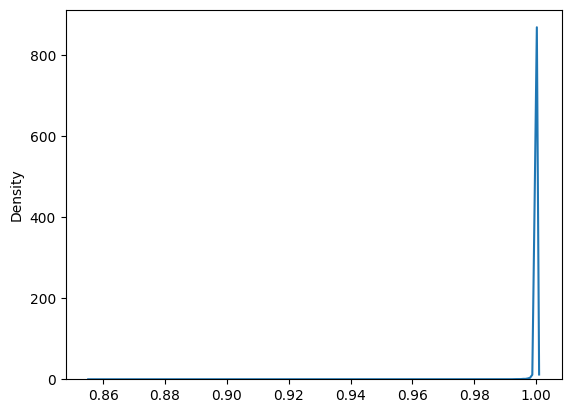

In [21]:
sns.kdeplot(tpm_correlation_list)

In [22]:
OmicsExpressionGenesExpectedCountProfile_tpm.isnull().sum().sum()

0

In [23]:
OmicsExpressionGenesExpectedCountProfile_tpm.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm = OmicsExpressionGenesExpectedCountProfile_tpm.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm = OmicsExpressionGenesExpectedCountModel_tpm.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

In [24]:
OmicsExpressionAllGenesTPMLogp1Profile.loc[:, "Model"] = OmicsExpressionAllGenesTPMLogp1Profile.index.map(profile_to_model_dict)
OmicsExpressionAllGenesTPMLogp1Model_tpm = OmicsExpressionAllGenesTPMLogp1Profile.set_index("Model")
OmicsExpressionAllGenesTPMLogp1Model_tpm = OmicsExpressionAllGenesTPMLogp1Model_tpm.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

In [25]:
OmicsExpressionAllGenesTPMLogp1Model_tpm.shape

(1882, 19193)

In [26]:
OmicsExpressionGenesExpectedCountModel_tpm.shape, OmicsExpressionProteinCodingGenesTPMLogp1.shape, OmicsExpressionAllGenesTPMLogp1Model_tpm.shape

((1882, 19193), (1882, 19193), (1882, 19193))

# Reproduce chrM bias

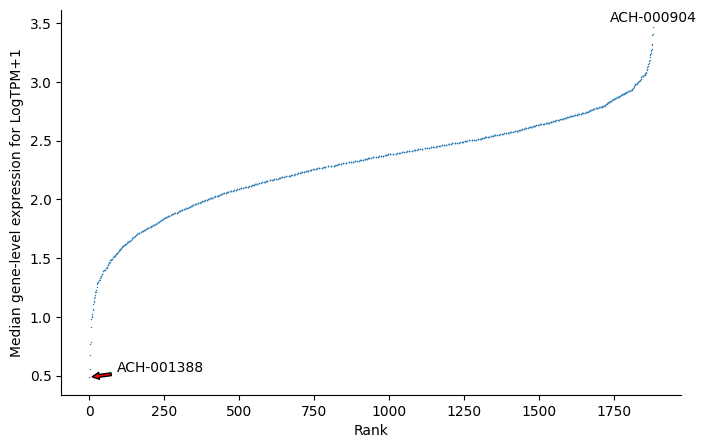

In [27]:
sample_median_expression = OmicsExpressionProteinCodingGenesTPMLogp1.median(axis=1)
sample_median_expression_rank = sample_median_expression.rank()
top_1_sample_index = sample_median_expression.argmax()
top_1_sample_rank = sample_median_expression_rank[top_1_sample_index]
top_1_sample = sample_median_expression.index[top_1_sample_index]
top_1_sample_expression = sample_median_expression[top_1_sample_index]
bottom_1_sample_index = sample_median_expression.argmin()
bottom_1_sample_rank = sample_median_expression_rank[bottom_1_sample_index]
bottom_1_sample = sample_median_expression.index[bottom_1_sample_index]
bottom_1_sample_expression = sample_median_expression[bottom_1_sample_index]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.scatterplot(y=sample_median_expression, x=sample_median_expression_rank, ax=ax, s=1)
ax.set_xlabel("Rank")
ax.set_ylabel("Median gene-level expression for LogTPM+1")
ax.annotate(top_1_sample, xy=(top_1_sample_rank, top_1_sample_expression), xytext=(0, 2), ha='center', textcoords='offset points', va='bottom')
ax.annotate(bottom_1_sample, xy=(bottom_1_sample_rank, bottom_1_sample_expression), 
            xytext=(bottom_1_sample_rank+50, 2), ha='center', va='bottom', textcoords='offset points', 
                arrowprops = dict(arrowstyle="simple", facecolor='red'))

sns.despine()

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


(0.0, 18.0)

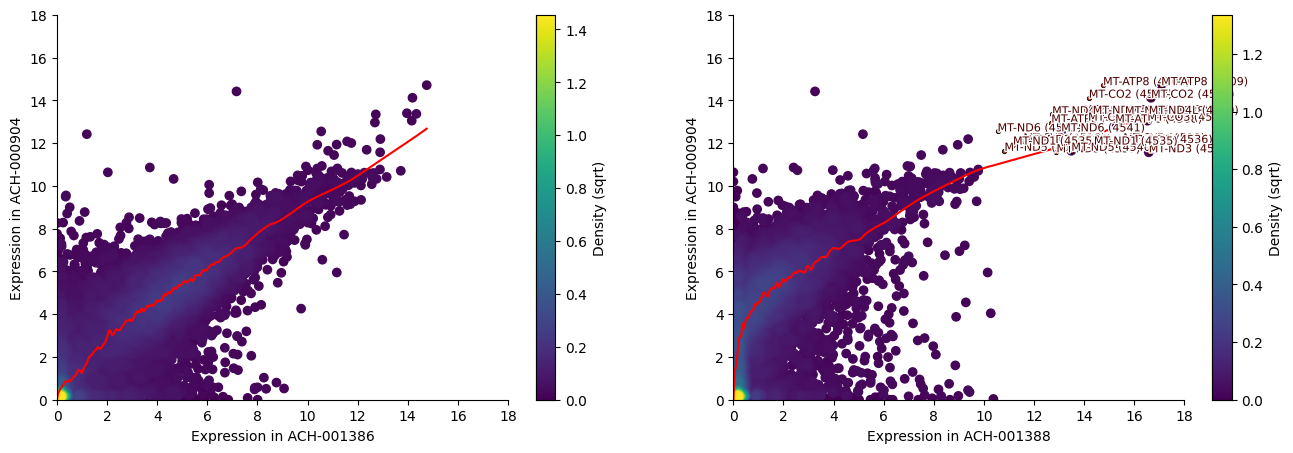

In [28]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm.columns[OmicsExpressionGenesExpectedCountModel_tpm.columns.str.contains("^MT-")]
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001386', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-001388")
ax[1].set_ylabel("Expression in ACH-000904")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)

Text(0.5, 0, 'All gene median expression')

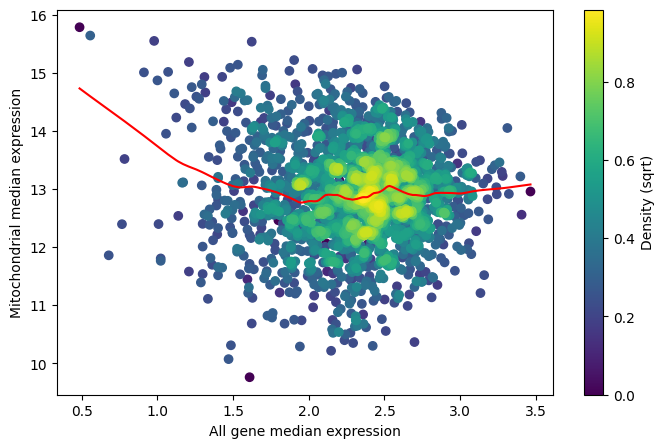

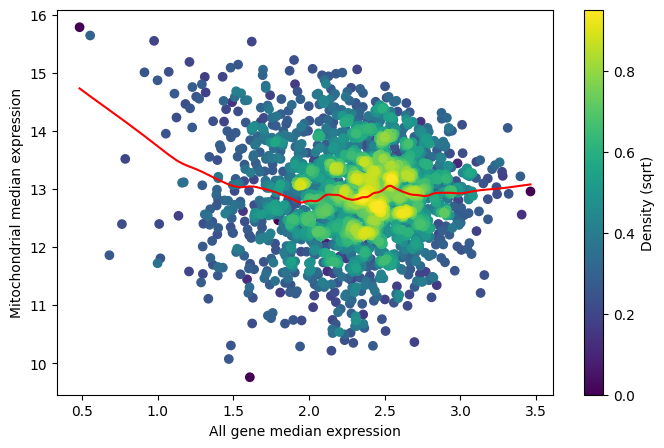

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, :].median(axis=1),
                         OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

# Apply the correction

In [30]:
def calculate_tpm_correct_chrM_log(counts_df, transcripts_length_df):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape
    EPSILON = 1e-300

    chrM_labels = counts_df.columns.str.contains("^MT-")
    print(chrM_labels.sum())

    denom = counts_df.loc[:, ~chrM_labels].sum(axis=1)
    denom = denom.where(denom > EPSILON, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    fpkm_sum = fpkm.loc[:, ~chrM_labels].sum(axis=1)
    fpkm_denom = fpkm_sum.where(fpkm_sum > EPSILON, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.log2(tpm_df+1)

In [31]:
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = calculate_tpm_correct_chrM_log(OmicsExpressionGenesExpectedCountProfile, 
                                                                                   OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.isnull()]
OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


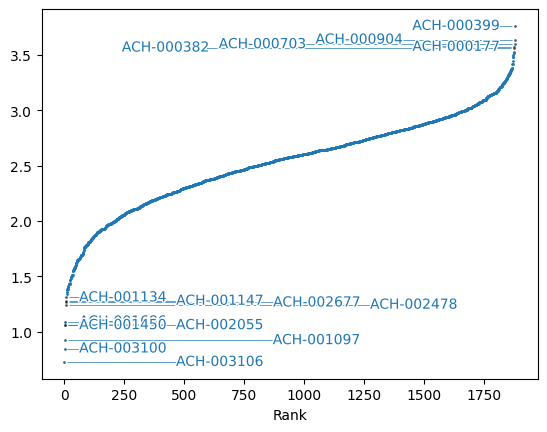

In [32]:
new_sample_median_expression = OmicsExpressionGenesExpectedCountModel_tpm_chrM.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_8190/166173770.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),


Text(0.5, 0, 'All gene median expression')

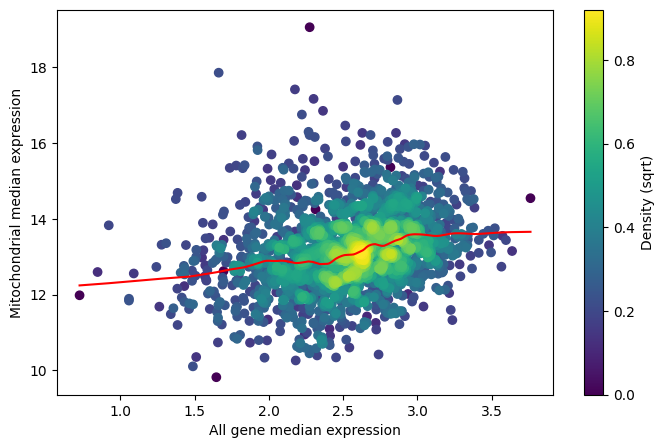

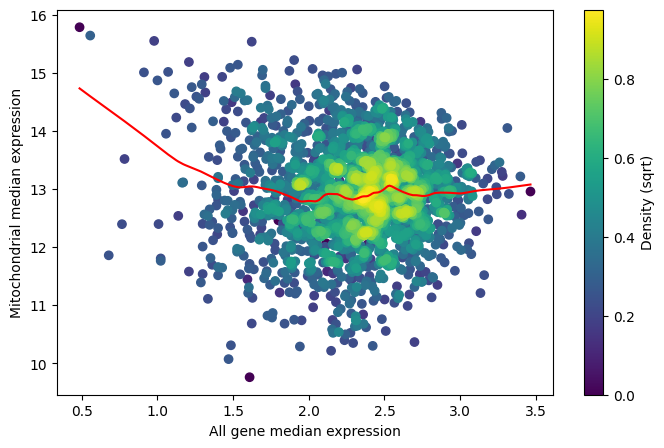

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


Text(0, 0.5, 'Expression in ACH-000904')

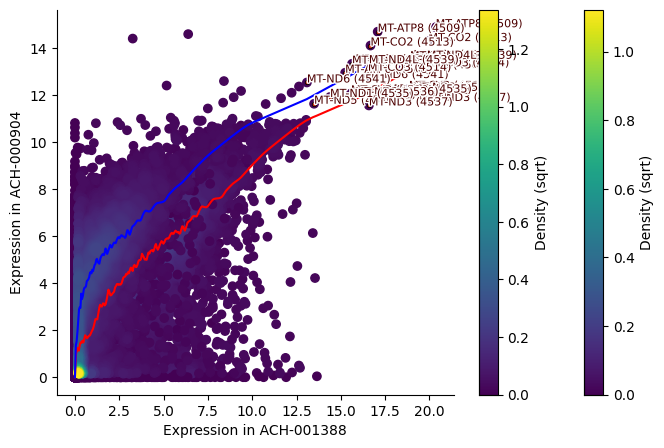

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

# fig, ax = plt.subplots()
# fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

In [35]:
ribo_labels = OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns[OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns.str.contains("^RPS")]
mito_labels = OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns[OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns.str.contains("^MT-")]

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


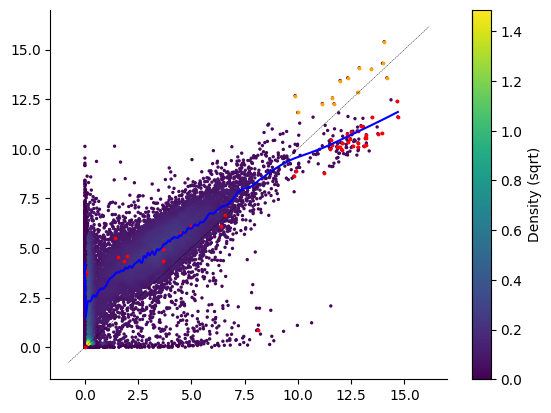

In [36]:
top_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[new_sample_median_expression.sort_values().tail().index, :].median(axis=0)
bottom_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[new_sample_median_expression.sort_values().head().index, :].median(axis=0)

fig, ax = plt.subplots()
plotting.density_scatter(bottom_chrM_corrected_samples, top_chrM_corrected_samples,
                         ax=ax, diagonal=True,
                         trend_line_args={'color': 'b'}, 
                         outlier_scatter_kws={'s': 1}, s=2)
ax.scatter(bottom_chrM_corrected_samples[chrM_labels], top_chrM_corrected_samples[chrM_labels], color='orange', s=3, label='chrM genes')
ax.scatter(bottom_chrM_corrected_samples[ribo_labels], top_chrM_corrected_samples[ribo_labels], color='r', s=3, label='ribosome genes')
sns.despine()

In [37]:
def calculate_tpm_correct_chrM_ribo_high_expressed_genes_log(counts_df, transcripts_length_df, 
                                                             quantile=0.95, ribo=True,
                                                             direct_tpm=False, 
                                                             high_expressed_labels = []):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape
    EPSILON = 1e-300

    chrM_labels = counts_df.columns[counts_df.columns.str.contains("^MT-")]
    ribo_labels = counts_df.columns[counts_df.columns.str.contains("^RPS")]

    high_expressed_labels = counts_df.columns[counts_df.mean(axis=0) >= counts_df.mean(axis=0).quantile(quantile)]
    print(len(high_expressed_labels))

    if ribo:
        all_labels = list(set(chrM_labels) | set(ribo_labels) | set(high_expressed_labels))
    else:
        all_labels = list(set(chrM_labels) | set(high_expressed_labels))

    is_in_labels = counts_df.columns.isin(all_labels)
    print(is_in_labels.sum())
    denom0 = counts_df.loc[:, is_in_labels].sum(axis=1)

    if not direct_tpm: # calculate fpkm then convert to tpm
        #do not delete genes from the total_counts now
        #denom = counts_df.loc[:, ~is_in_labels].sum(axis=1)
        denom = counts_df.sum(axis=1)
        denom = denom.where(denom > EPSILON, 1)
        print(denom.isnull().sum().sum())
        # counts / total_counts
        frac = counts_df.div(denom, axis=0)
        print(frac.isnull().sum().sum())

        transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)

        # fpkm = counts / total_counts * 1e9 / transcripts_length
        fpkm = frac * 1e9 / transcripts_length_df
        print(fpkm.isnull().sum().sum())

        #delete genes from the total_counts here
        fpkm_sum = fpkm.loc[:, ~is_in_labels].sum(axis=1)
        deleted_ratio = fpkm_sum / fpkm.sum(axis=1)
        print(deleted_ratio.mean())

        fpkm_denom = fpkm_sum.where(fpkm_sum > EPSILON, 1)
        print(fpkm_denom.isnull().sum().sum())

        # fpkm = (counts / total_counts * 1e9 / transcripts_length)
        # tpm = fpkm / fpkm.sum()
        tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
        print(tpm_df.isnull().sum().sum())
    else:
        counts = counts_df.where(counts_df > EPSILON, 1)
        transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)
        ratio_per_base = counts / transcripts_length_df
        ratio_per_base_sum = ratio_per_base.loc[:, ~is_in_labels].sum(axis=1)
        ratio_per_base_sum = ratio_per_base_sum.where(ratio_per_base_sum > EPSILON, 1)
        tpm_df = ratio_per_base / ratio_per_base * 1e6

    # removed genes, removed counts ratio, removed counts_per_base ratio, tpm corrected
    return is_in_labels.sum(), (denom0 / counts_df.sum(axis=1)), 1-deleted_ratio, np.log2(tpm_df+1)

In [38]:
old_mean_exp = OmicsExpressionAllGenesTPMLogp1Profile.iloc[:, :-1].median(axis=1)

old_tpm_correlation_list = []
for gene in OmicsExpressionAllGenesTPMLogp1Profile.columns[:-1]:
    old_tpm_correlation_list.append(pearsonr(old_mean_exp, OmicsExpressionAllGenesTPMLogp1Profile.loc[:, gene])[0])

In [39]:
len(old_tpm_correlation_list)

19193

In [40]:
old_mean_exp = OmicsExpressionProteinCodingGenesTPMLogp1.median(axis=1)

old_tpm_correlation_list = []
for gene in OmicsExpressionProteinCodingGenesTPMLogp1.columns:
    old_tpm_correlation_list.append(pearsonr(old_mean_exp, OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, gene])[0])

In [41]:
overlapped_genes = np.intersect1d(OmicsExpressionProteinCodingGenesTPMLogp1.columns, df_gene_effect.columns)
overlapped_lines = np.intersect1d(OmicsExpressionProteinCodingGenesTPMLogp1.index, df_gene_effect.index)

In [42]:
OmicsExpressionProteinCodingGenesTPMLogp1.shape, OmicsExpressionAllGenesTPMLogp1Profile.shape

((1882, 19193), (1904, 19194))

In [43]:
overlapped_genes.shape, overlapped_lines.shape

((18280,), (1172,))

In [44]:
df_gene_effect = df_gene_effect.loc[overlapped_lines, :].loc[:, overlapped_genes]

In [45]:
df_gene_exp = OmicsExpressionProteinCodingGenesTPMLogp1.loc[:, overlapped_genes].loc[overlapped_lines, :]

In [46]:
OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes.shape, OmicsExpressionGenesExpectedCountProfile.shape

((1904, 54353), (1904, 54353))

In [47]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import pandas as pd
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X) 

[0.99244289 0.00755711]


PCA(n_components=2)

In [49]:
iris = load_iris()
print(iris.data.shape)
df = pd.DataFrame(iris.data)
pca = PCA(n_components=4)
pca.fit(df)

(150, 4)
[0.92461872 0.05306648 0.01710261 0.00521218]


PCA(n_components=4)

2718
2718
0
0
0
0.23476916679215581
0
0


/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


PR-AdBjpG    0.646312
PR-I2AzwG    0.626035
PR-5ekAAC    0.689011
PR-DuAy1L    0.681173
PR-pGHJuj    0.704433
               ...   
PR-ACNZor    0.623880
PR-eZ3iv8    0.708291
PR-RWNv81    0.721782
PR-IVFp8S    0.666332
PR-AsIpQ0    0.631059
Length: 1904, dtype: float64
[0.5430836268279254, 0.06195235462406595, 0.1903157159430118, 0.06558361644507649, 0.19115106455414757, -0.4100072980714965, 0.22054491790026653, 0.33941866949300864, 0.21609496102886122, 0.20770746699388248, 0.24809963194082588, 0.24235713170338702, 0.07071608199565488, 0.07055259688808148, 0.3688304867864594, 0.05495188731801286, 0.5207703788901992, 0.16413465751470296, 0.33799971441250465, 0.25691773619493236, 0.31453064411935294, 0.09741373381736904, 0.1930441325368677, 0.22702406671941666, 0.02205940879748678, 0.07714347041985914, 0.21302752856282361, -0.01860466488135043, 0.3029769771395372, 0.12619869502904996, 0.10600942646607148, 0.12233791840758815, 0.32142623668187875, 0.3744262936904129, 0.15808311271540126,

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


1088
1088
0
0
0
0.34838423238427474
0
0


/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


PR-AdBjpG    0.449469
PR-I2AzwG    0.440597
PR-5ekAAC    0.506140
PR-DuAy1L    0.500986
PR-pGHJuj    0.516843
               ...   
PR-ACNZor    0.436752
PR-eZ3iv8    0.531734
PR-RWNv81    0.539327
PR-IVFp8S    0.475920
PR-AsIpQ0    0.452441
Length: 1904, dtype: float64
[0.49655399415357077, 0.06177205041117283, 0.11447231279701142, 0.059378170766871796, 0.17341829634988504, -0.38224250109203306, 0.18077748925791404, 0.2902421528798934, 0.1942293920375563, 0.20672706616937986, 0.2151301743057861, 0.21801243089264186, 0.04256961517660733, 0.08262508094096391, 0.34295092432838864, 0.04740932585328209, 0.49349738393467557, 0.12594705408850354, 0.3218197621129212, 0.27055375860680614, 0.3020453937666731, 0.04956461836806908, 0.1566115556292456, 0.20171404886772593, 0.013719295265405423, 0.05535545127116658, 0.18260734637156623, -0.02082427273575644, 0.24453504195718295, 0.0918678024428276, 0.11389820727005945, 0.07523463261001459, 0.3202961637304192, 0.3497472410718726, 0.18450244814060418

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


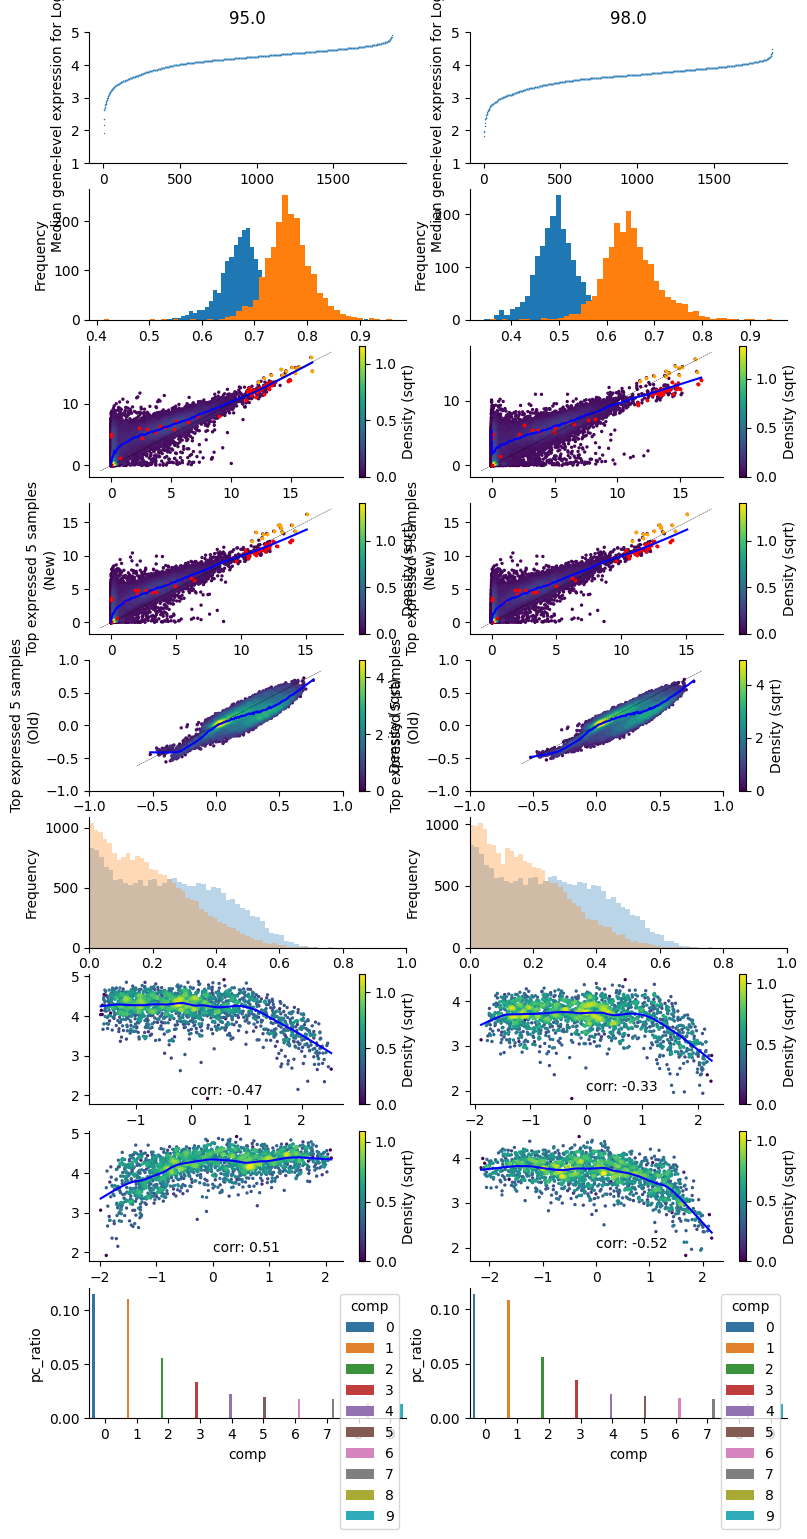

In [53]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots(9, 2)
fig.set_size_inches(9, 18)
n = 0
remove_genes_stat = []
for quantile in [0.95, 0.98]:
    removed_genes95, removed_counts95, removed_counts_pb95, OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95 = calculate_tpm_correct_chrM_ribo_high_expressed_genes_log(OmicsExpressionGenesExpectedCountProfile, 
                                                                                                                      OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes,
                                                                                                                      quantile=quantile, ribo=False, direct_tpm=False)
    OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.columns.map(protcod_rename)
    OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95 = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.columns.isnull()]
    
    OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.index.map(profile_to_model_dict)
    OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95 = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.set_index("Model")
    OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95 = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

    top_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[new_sample_median_expression.sort_values().tail().index, :].median(axis=0)
    bottom_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[new_sample_median_expression.sort_values().head().index, :].median(axis=0)
    
    plotting.density_scatter(bottom_chrM_corrected_samples, top_chrM_corrected_samples,
                             ax=ax[3][n], diagonal=True,
                             trend_line_args={'color': 'b'}, 
                             outlier_scatter_kws={'s': 1}, s=2)
    ax[3][n].scatter(bottom_chrM_corrected_samples[chrM_labels], top_chrM_corrected_samples[chrM_labels], color='orange', s=3, label='chrM genes')
    ax[3][n].scatter(bottom_chrM_corrected_samples[ribo_labels], top_chrM_corrected_samples[ribo_labels], color='r', s=3, label='ribosome genes')
    ax[3][n].set_xlabel("Bottom expressed 5 samples")
    ax[3][n].set_ylabel("Top expressed 5 samples\n(New)")
    sns.despine()

    new_sample_median_expression = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95.median(axis=1)
    new_sample_median_expression_rank = new_sample_median_expression.rank()

    sns.scatterplot(y=new_sample_median_expression, x=new_sample_median_expression_rank, ax=ax[0][n], s=1)
    ax[0][n].set_xlabel("Rank")
    ax[0][n].set_ylim(1, 5)
    ax[0][n].set_ylabel("Median gene-level expression for LogTPM+1")
    ax[0][n].set_title(quantile*100)
    print(removed_counts95)

    ax[1][n].hist(removed_counts95, bins=50, label='Lost Total Counts %')
    ax[1][n].hist(removed_counts_pb95, bins=50, label='Lost Total Counts per bases %')
    ax[1][n].set_xlabel("Value")
    ax[1][n].set_ylabel("Frequency")

    if n == 4:
        ax[1][n].legend()

    new_tpm_correlation_list = []
    old_mean_exp = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.iloc[:, :-1].median(axis=1)
    for gene in OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.columns[:-1]:
        new_tpm_correlation_list.append(pearsonr(old_mean_exp, OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.loc[:, gene])[0])
    print(new_tpm_correlation_list)

    plotting.density_scatter(np.array(old_tpm_correlation_list), np.array(new_tpm_correlation_list),
                             diagonal=True, ax=ax[4][n],
                             trend_line_args={'color': 'b'}, 
                             outlier_scatter_kws={'s': 1}, s=2)    
    ax[4][n].set_xlabel("Old expression correlation\nwith median")
    ax[4][n].set_ylabel("new expression correlation\nwith median")
    ax[4][n].set_xlim(-1, 1)
    ax[4][n].set_ylim(-1, 1)

    ax[4][n].set_xlabel("Bottom expressed 5 samples")
    ax[4][n].set_ylabel("Top expressed 5 samples\n(Old)")

    ax[5][n].hist(np.abs(np.array(old_tpm_correlation_list)), bins=50, label='Old', alpha=0.3)
    ax[5][n].hist(np.abs(np.array(new_tpm_correlation_list)), bins=50, label='New', alpha=0.3)
    ax[5][n].set_xlabel("Value")
    ax[5][n].set_ylabel("Frequency")
    ax[5][n].set_xlim(0, 1)
    if n == 5:
        ax[5][n].legend()

    top_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95.loc[new_sample_median_expression.sort_values().tail().index, :].median(axis=0)
    bottom_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95.loc[new_sample_median_expression.sort_values().head().index, :].median(axis=0)
    
    plotting.density_scatter(bottom_chrM_corrected_samples, top_chrM_corrected_samples,
                             ax=ax[2][n], diagonal=True,
                             trend_line_args={'color': 'b'}, 
                             outlier_scatter_kws={'s': 1}, s=2)
    ax[2][n].scatter(bottom_chrM_corrected_samples[chrM_labels], top_chrM_corrected_samples[chrM_labels], color='orange', s=3, label='chrM genes')
    ax[2][n].scatter(bottom_chrM_corrected_samples[ribo_labels], top_chrM_corrected_samples[ribo_labels], color='r', s=3, label='ribosome genes')

    old_mean_exp = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95.iloc[:, :-1].median(axis=1)
    pca = PCA(n_components=10, whiten=True, random_state=99)
    components = pca.fit_transform(OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95)

    plotting.density_scatter(components[:, 0], old_mean_exp,
                             diagonal=False, ax=ax[6][n],
                             trend_line_args={'color': 'b'}, 
                             outlier_scatter_kws={'s': 1}, s=2) 

    ax[6][n].text(0, 2, "corr: %.2f" % pearsonr(components[:, 0], old_mean_exp)[0])
    plotting.density_scatter(components[:, 1], old_mean_exp,
                             diagonal=False, ax=ax[7][n],
                             trend_line_args={'color': 'b'}, 
                             outlier_scatter_kws={'s': 1}, s=2) 
    ax[7][n].text(0, 2, "corr: %.2f" % pearsonr(components[:, 1], old_mean_exp)[0])

    df = pd.DataFrame({'pc_ratio': pca.explained_variance_ratio_, 'comp': np.arange(10)})
    sns.barplot(df, x="comp", y="pc_ratio", hue="comp", ax=ax[8][n])
    n += 1


In [54]:
expected_counts = OmicsExpressionGenesExpectedCountProfile.copy()
expected_counts.columns = OmicsExpressionGenesExpectedCountProfile.columns.map(protcod_rename)
expected_counts = expected_counts.loc[:, ~expected_counts.columns.isnull()]

In [55]:
effected_len = OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes.copy()
effected_len.columns = OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes.columns.map(protcod_rename)
effected_len = effected_len.loc[:, ~effected_len.columns.isnull()]

7677
7677
0
0
0
0.05713764071007557
0
0
PR-AdBjpG    0.920700
PR-I2AzwG    0.900491
PR-5ekAAC    0.934875
PR-DuAy1L    0.923092
PR-pGHJuj    0.935788
               ...   
PR-ACNZor    0.912990
PR-eZ3iv8    0.940799
PR-RWNv81    0.945115
PR-IVFp8S    0.925904
PR-AsIpQ0    0.895752
Length: 1904, dtype: float64


/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


5758
5758
0
0
0
0.09943577786184796
0
0
PR-AdBjpG    0.851839
PR-I2AzwG    0.827164
PR-5ekAAC    0.875030
PR-DuAy1L    0.864843
PR-pGHJuj    0.878211
               ...   
PR-ACNZor    0.836849
PR-eZ3iv8    0.883327
PR-RWNv81    0.891456
PR-IVFp8S    0.858686
PR-AsIpQ0    0.826546
Length: 1904, dtype: float64


/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


1920
1920
0
0
0
0.25997584246196787
0
0
PR-AdBjpG    0.565322
PR-I2AzwG    0.553731
PR-5ekAAC    0.620169
PR-DuAy1L    0.614132
PR-pGHJuj    0.633979
               ...   
PR-ACNZor    0.557750
PR-eZ3iv8    0.641102
PR-RWNv81    0.653091
PR-IVFp8S    0.591073
PR-AsIpQ0    0.566811
Length: 1904, dtype: float64


/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


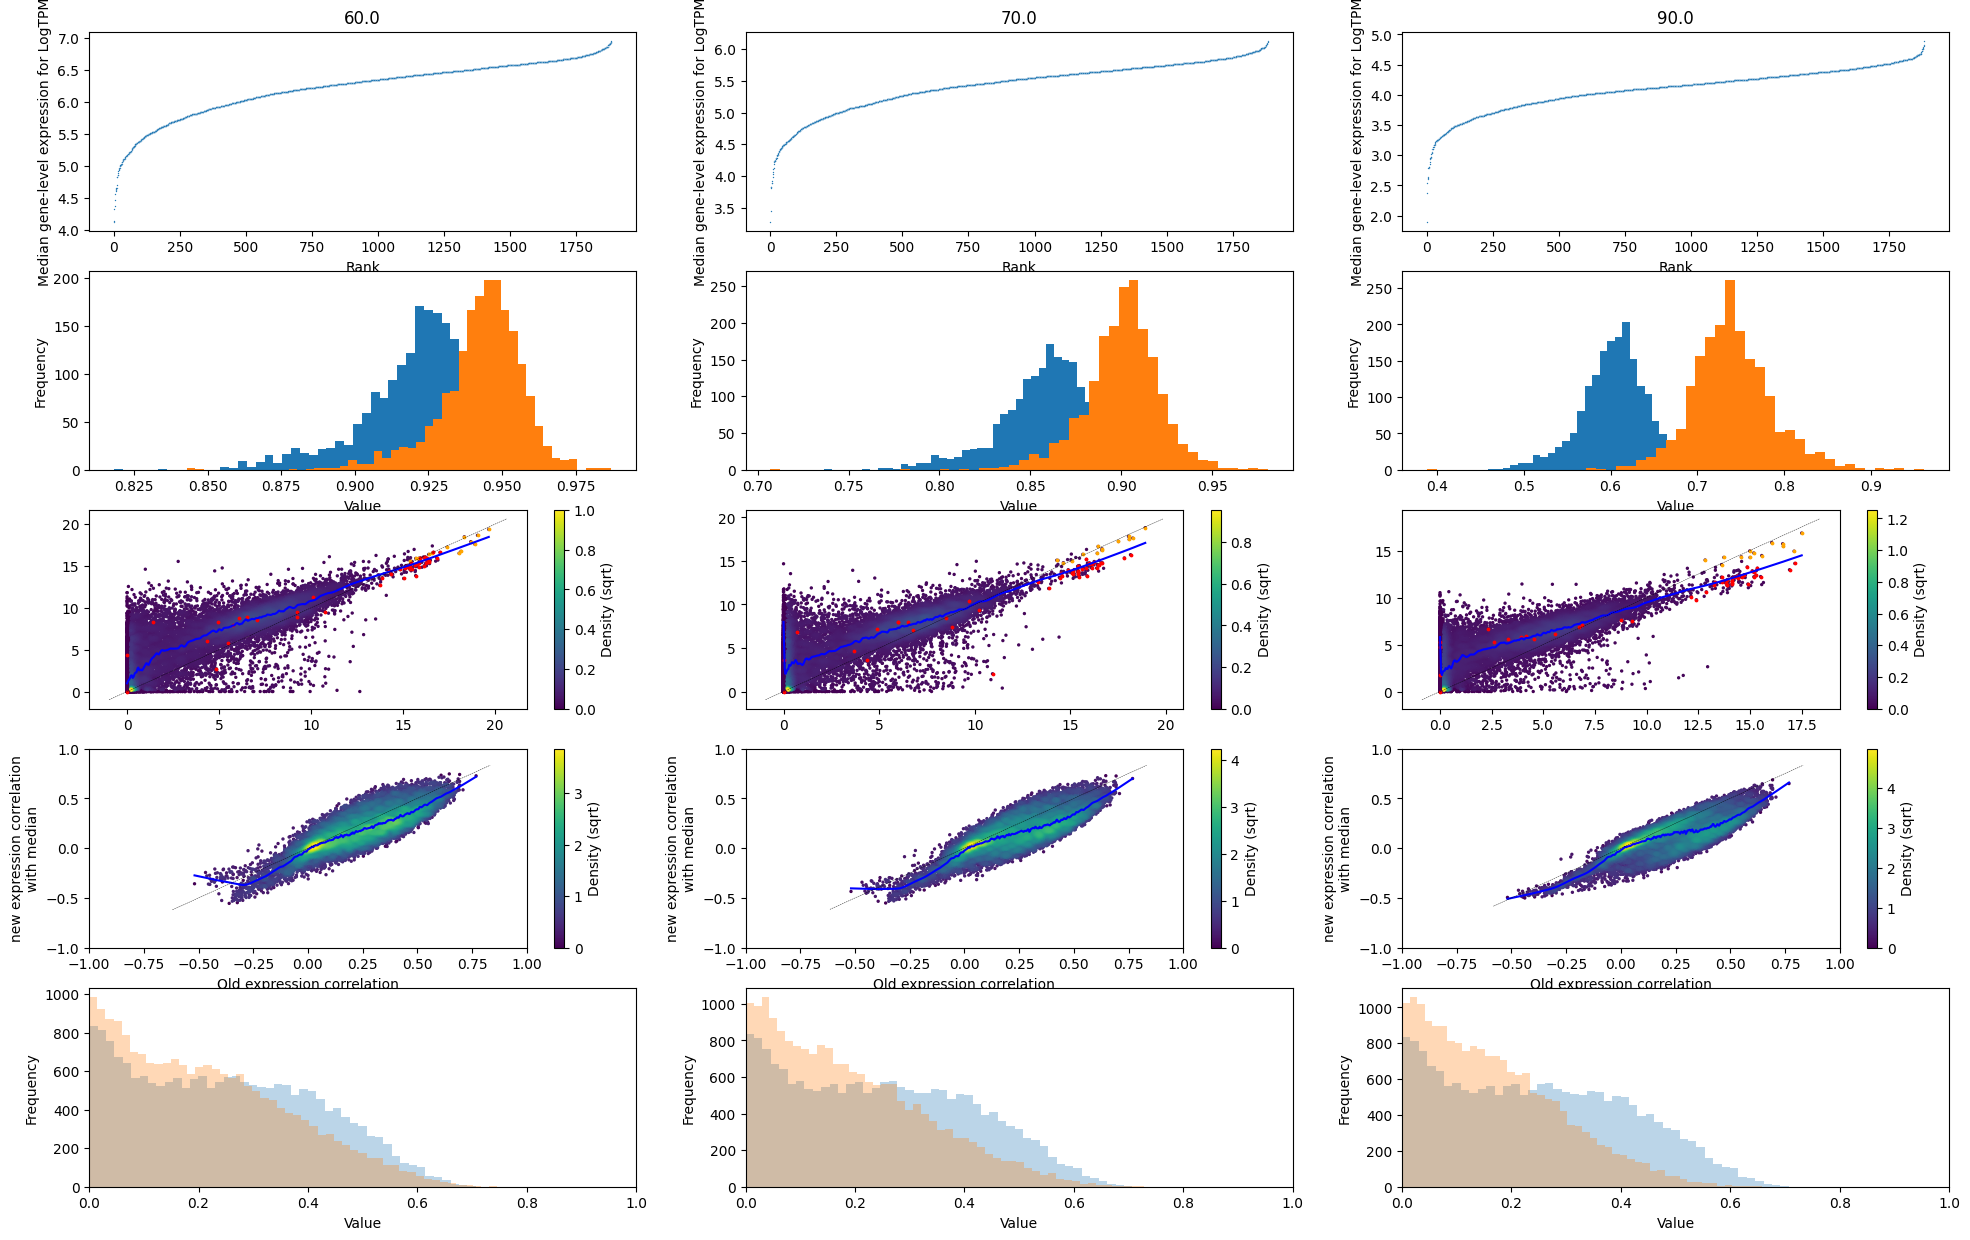

In [56]:
from scipy.stats import pearsonr

fig, ax = plt.subplots(5, 3)
fig.set_size_inches(24, 15)
n = 0
remove_genes_stat = []
for quantile in [0.6, 0.7, 0.9]:
    removed_genes95, removed_counts95, removed_counts_pb95, OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95 = calculate_tpm_correct_chrM_ribo_high_expressed_genes_log(expected_counts,
                                                                                                                       effected_len,
                                                                                                                       quantile=quantile, ribo=False, direct_tpm=False)
    
    OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.index.map(profile_to_model_dict)
    OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95 = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.set_index("Model")
    OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95 = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

    new_sample_median_expression = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95.median(axis=1)
    new_sample_median_expression_rank = new_sample_median_expression.rank()

    #plotting.waterfall_plot(new_sample_median_expression, s=5, ax=ax[n])
    top_1_sample_index = new_sample_median_expression.argmax()
    top_1_sample_rank = new_sample_median_expression_rank[top_1_sample_index]
    top_1_sample = new_sample_median_expression.index[top_1_sample_index]
    top_1_sample_expression = new_sample_median_expression[top_1_sample_index]
    bottom_1_sample_index = new_sample_median_expression.argmin()
    bottom_1_sample_rank = new_sample_median_expression_rank[bottom_1_sample_index]
    bottom_1_sample = new_sample_median_expression.index[bottom_1_sample_index]
    bottom_1_sample_expression = new_sample_median_expression[bottom_1_sample_index]
    
    sns.scatterplot(y=new_sample_median_expression, x=new_sample_median_expression_rank, ax=ax[0][n], s=1)
    ax[0][n].set_xlabel("Rank")
    ax[0][n].set_ylabel("Median gene-level expression for LogTPM+1")
    ax[0][n].set_title(quantile*100)
    print(removed_counts95)

    ax[1][n].hist(removed_counts95, bins=50, label='Lost Total Counts %')
    ax[1][n].hist(removed_counts_pb95, bins=50, label='Lost Total Counts per bases %')
    ax[1][n].set_xlabel("Value")
    ax[1][n].set_ylabel("Frequency")

    if n == 4:
        ax[1][n].legend()

    old_mean_exp = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.iloc[:, :-1].median(axis=1)
    new_tpm_correlation_list = []
    for gene in OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.columns[:-1]:
        new_tpm_correlation_list.append(pearsonr(old_mean_exp, OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo95.loc[:, gene])[0])

    plotting.density_scatter(np.array(old_tpm_correlation_list), np.array(new_tpm_correlation_list),
                             diagonal=True, ax=ax[3][n],
                             trend_line_args={'color': 'b'}, 
                             outlier_scatter_kws={'s': 1}, s=2)    
    ax[3][n].set_xlabel("Old expression correlation\nwith median")
    ax[3][n].set_ylabel("new expression correlation\nwith median")

    ax[3][n].set_xlim(-1, 1)
    ax[3][n].set_ylim(-1, 1)

    ax[4][n].hist(np.abs(np.array(old_tpm_correlation_list)), bins=50, label='Old', alpha=0.3)
    ax[4][n].hist(np.abs(np.array(new_tpm_correlation_list)), bins=50, label='New', alpha=0.3)
    ax[4][n].set_xlabel("Value")
    ax[4][n].set_ylabel("Frequency")
    ax[4][n].set_xlim(0, 1)
    if n == 4:
        ax[4][n].legend()

    #ax[0][n].annotate(top_1_sample, xy=(top_1_sample_rank, top_1_sample_expression), xytext=(0, 2), ha='center', textcoords='offset points', va='bottom')
    #ax[0][n].annotate(bottom_1_sample, xy=(bottom_1_sample_rank, bottom_1_sample_expression), 
    #            xytext=(bottom_1_sample_rank+50, 2), ha='center', va='bottom', textcoords='offset points', 
    #                arrowprops = dict(arrowstyle="simple", facecolor='red'))

    top_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95.loc[new_sample_median_expression.sort_values().tail().index, :].median(axis=0)
    bottom_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo95.loc[new_sample_median_expression.sort_values().head().index, :].median(axis=0)
    
    plotting.density_scatter(bottom_chrM_corrected_samples, top_chrM_corrected_samples,
                             ax=ax[2][n], diagonal=True,
                             trend_line_args={'color': 'b'}, 
                             outlier_scatter_kws={'s': 1}, s=2)
    #ax[n].scatter(bottom_chrM_corrected_samples, top_chrM_corrected_samples, color='gray', s=3, label='chrM genes')
    ax[2][n].scatter(bottom_chrM_corrected_samples[chrM_labels], top_chrM_corrected_samples[chrM_labels], color='orange', s=3, label='chrM genes')
    ax[2][n].scatter(bottom_chrM_corrected_samples[ribo_labels], top_chrM_corrected_samples[ribo_labels], color='r', s=3, label='ribosome genes')
    n += 1

In [ ]:
# old_mean_exp = OmicsExpressionProteinCodingGenesTPMLogp1.median(axis=1)

# old_tpm_correlation_list = []
# for gene in overlapped_genes:
#     geff = df_gene_effect.loc[:, gene]
#     gexp = df_gene_exp.loc[:, gene]
#     valid_index = np.isnan(geff) | np.isnan(gexp)
#     #print(geff[~valid_index].shape)
#     #print(gexp[~valid_index].shape)
#     old_tpm_correlation_list.append(pearsonr(geff[~valid_index], gexp[~valid_index])[0])
# plt.hist(old_tpm_correlation_list, bins=50)

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


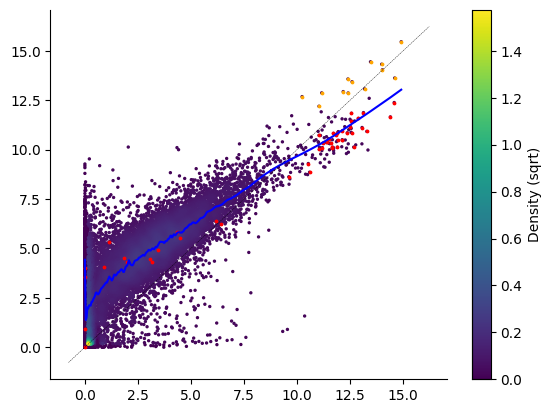

In [56]:
top_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[new_sample_median_expression.sort_values().tail().index, :].median(axis=0)
bottom_chrM_corrected_samples = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[new_sample_median_expression.sort_values().head().index, :].median(axis=0)

fig, ax = plt.subplots()
plotting.density_scatter(bottom_chrM_corrected_samples, top_chrM_corrected_samples,
                         ax=ax, diagonal=True,
                         trend_line_args={'color': 'b'}, 
                         outlier_scatter_kws={'s': 1}, s=2)
ax.scatter(bottom_chrM_corrected_samples[chrM_labels], top_chrM_corrected_samples[chrM_labels], color='orange', s=3, label='chrM genes')
ax.scatter(bottom_chrM_corrected_samples[ribo_labels], top_chrM_corrected_samples[ribo_labels], color='r', s=3, label='ribosome genes')
sns.despine()

In [ ]:
from scipy.stats import pearsonr

fig, ax = plt.subplots(5, 5)
fig.set_size_inches(24, 22)
n = 0
remove_genes_stat = []
for quantile in [0.95]:
    removed_genes, removed_counts, removed_counts_pb, OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo = calculate_tpm_correct_chrM_ribo_high_expressed_genes_log(OmicsExpressionGenesExpectedCountProfile, 
                                                                                                                      OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes,
                                                                                                                      quantile=quantile, ribo=False, direct_tpm=False)
    OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo.columns.map(protcod_rename)
    OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo.columns.isnull()]
    
    OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo.index.map(profile_to_model_dict)
    OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo = OmicsExpressionGenesExpectedCountProfile_tpm_chrM_ribo.set_index("Model")
    OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo = OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

In [167]:
OmicsExpressionGenesExpectedCountModel_tpm_chrM_ribo.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_chrM_95percentile_highexpressed.csv")

In [168]:
update = False
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-8a6b",
        changes_description="post 23Q4 adjust gene expression normalization 2",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-chrM-95percentilehighexpressed",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_95percentile_highexpressed.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_95percentile_highexpressed", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

Uploading OmicsExpressionGenesExpectedCountModel_tpm_chrM_95percentile_highexpressed to S3
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_chrM_95percentile_highexpressed to S3
Uploading OmicsExpressionGenesExpectedCountModel_tpm_chrM_95percentile_highexpressed to Taiga
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_chrM_95percentile_highexpressed to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/3e08ad374b254988a969dd771062fc0f



'3e08ad374b254988a969dd771062fc0f'

## Upload this new version of datasets

In [42]:
OmicsExpressionGenesExpectedCountModel_tpm_chrM.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv")

In [43]:
update = True
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-8a6b",
        changes_description="post 23Q4 adjust gene expression normalization 2",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-chrM",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

No dataset version provided. Using version 3.
Linking virtual file OmicsExpressionGenesExpectedCountModel_tpm_chrM
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/cc3e017b99e2400a86479d2d2828ddc3


'cc3e017b99e2400a86479d2d2828ddc3'

# Square root normalization

In [54]:
def calculate_tpm_correct_chrM(counts_df, transcripts_length_df, chrM=True):
    """https://github.com/deweylab/RSEM/blob/8bc1e2115493c0cdf3c6bee80ef7a21a91b2acce/WriteResults.h#L77"""
    assert counts_df.shape == transcripts_length_df.shape
    EPSILON = 1e-300

    chrM_labels = counts_df.columns.str.contains("^MT-")
    print(chrM_labels.sum())

    if chrM:
        denom = counts_df.loc[:, ~chrM_labels].sum(axis=1)
    else:
        denom = counts_df.sum(axis=1)

    denom = denom.where(denom > EPSILON, 1)
    print(denom.isnull().sum().sum())
    frac = counts_df.div(denom, axis=0)
    print(frac.isnull().sum().sum())

    transcripts_length_df = transcripts_length_df.where(transcripts_length_df > EPSILON, 1)
    fpkm = frac * 1e9 / transcripts_length_df
    print(fpkm.isnull().sum().sum())

    if chrM:
        fpkm_sum = fpkm.loc[:, ~chrM_labels].sum(axis=1)
    else:
        fpkm_sum = fpkm.sum(axis=1)

    fpkm_denom = fpkm_sum.where(fpkm_sum > EPSILON, 1)
    print(fpkm_denom.isnull().sum().sum())

    tpm_df = (fpkm.div(fpkm_denom, axis=0)) * 1e6
    print(tpm_df.isnull().sum().sum())
    return np.sqrt(tpm_df+1)

In [55]:
OmicsExpressionGenesExpectedCountProfile_tpm_sqrt = calculate_tpm_correct_chrM(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes, chrM=False)
OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.columns = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_sqrt = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_sqrt = OmicsExpressionGenesExpectedCountProfile_tpm_sqrt.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_sqrt = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


In [56]:
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = calculate_tpm_correct_chrM(OmicsExpressionGenesExpectedCountProfile, 
                                                                               OmicsExpressionAllGenesEffectiveLengthProfile_matched_genes)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.map(protcod_rename)
OmicsExpressionGenesExpectedCountProfile_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, ~OmicsExpressionGenesExpectedCountProfile_tpm_chrM.columns.isnull()]

OmicsExpressionGenesExpectedCountProfile_tpm_chrM.loc[:, "Model"] = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.index.map(profile_to_model_dict)
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountProfile_tpm_chrM.set_index("Model")
OmicsExpressionGenesExpectedCountModel_tpm_chrM = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[OmicsExpressionProteinCodingGenesTPMLogp1.index, :]

15
0
0
0
0
0


Text(0.5, 0, 'All gene median expression')

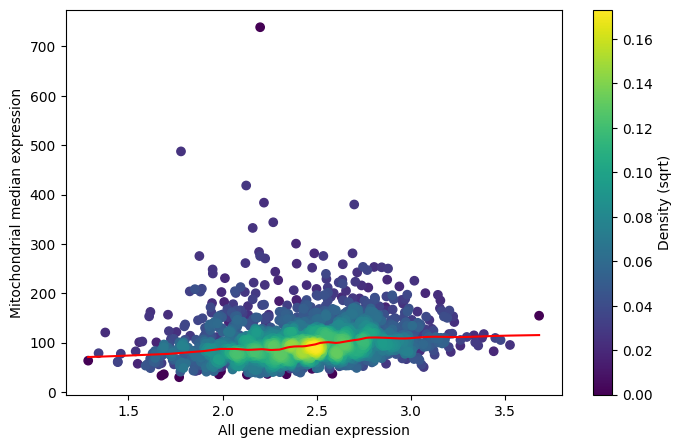

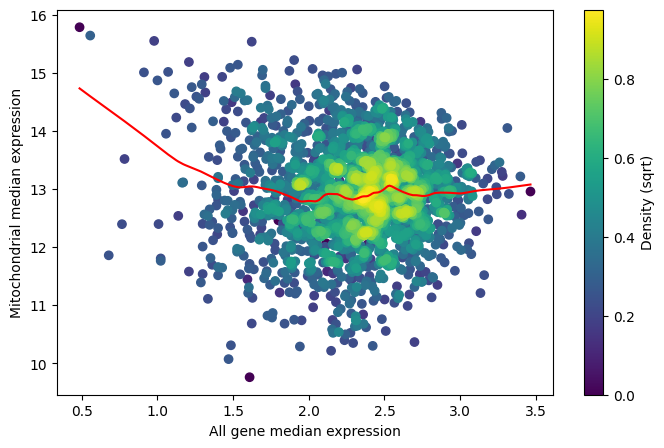

In [57]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns[OmicsExpressionGenesExpectedCountModel_tpm_chrM.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")
#ax.set_ylim(0, 200)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

Text(0.5, 0, 'All gene median expression')

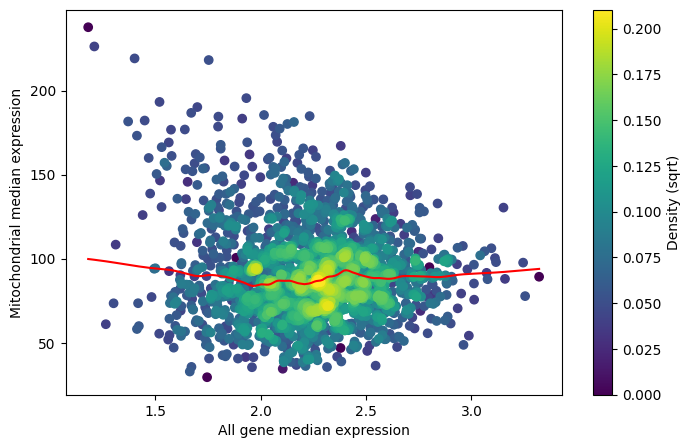

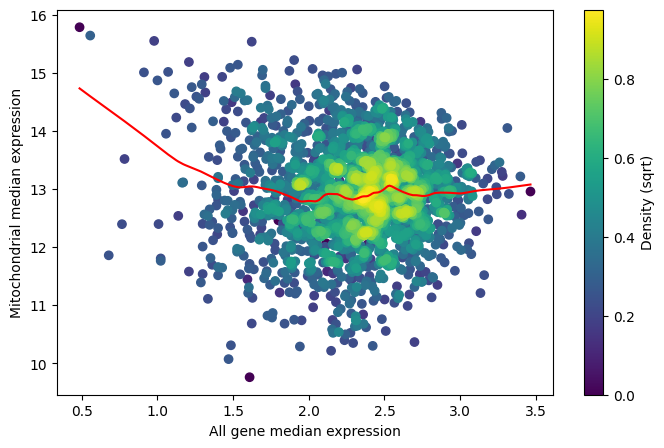

In [62]:
chrM_labels = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.columns[OmicsExpressionGenesExpectedCountModel_tpm_sqrt.columns.str.contains("^MT-")]

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc[:, :].median(axis=1),
                         OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")
#ax.set_ylim(0, 200)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
plotting.density_scatter(OmicsExpressionAllGenesTPMLogp1Profile.loc[:, :].median(axis=1),
                         OmicsExpressionAllGenesTPMLogp1Profile.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


Text(0, 0.5, 'Expression in ACH-000904')

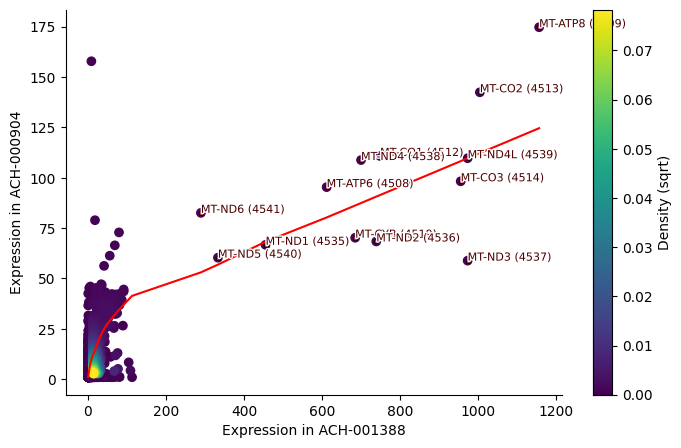

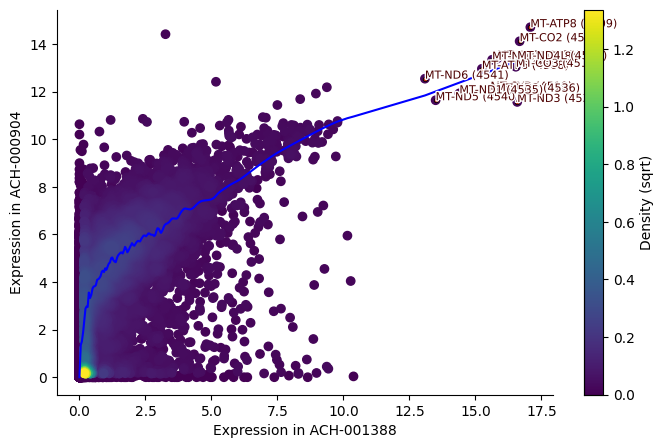

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_chrM.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

Text(0, 0.5, 'Expression in ACH-000904')

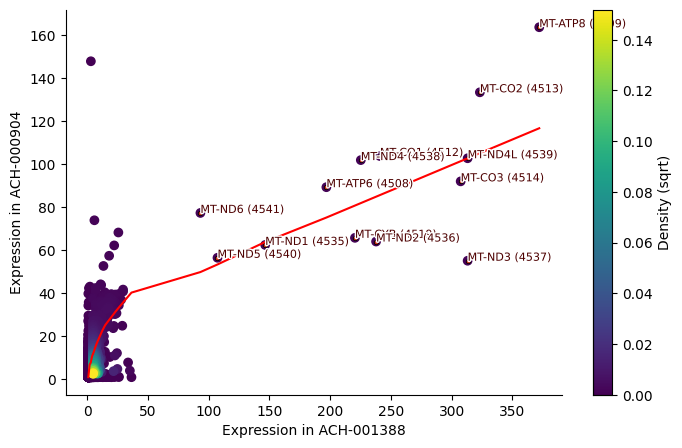

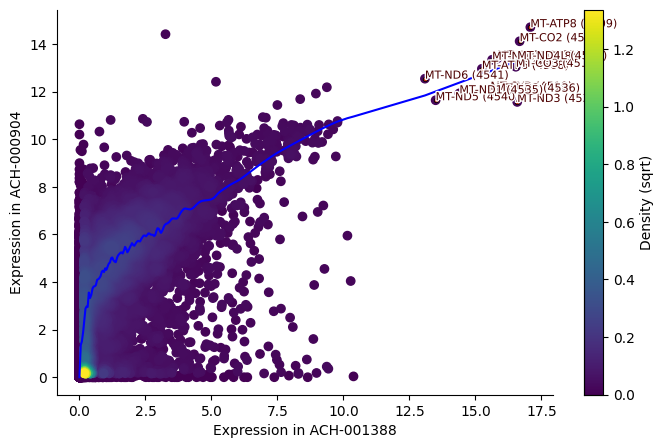

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)

highest_sample = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm_sqrt.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         label_specific=chrM_labels)
sns.despine()
                         
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[0].set_xlim(0, 18)
#ax[0].set_ylim(0, 18)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
highest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-001388', :]
lowest_sample = OmicsExpressionGenesExpectedCountModel_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax,
                         trend_line_args={'color': 'b'},
                         label_specific=chrM_labels)
sns.despine()
                       
ax.set_xlabel("Expression in ACH-001388")
ax.set_ylabel("Expression in ACH-000904")
#ax[1].set_xlim(0, 18)
#ax[1].set_ylim(0, 18)

In [63]:
OmicsExpressionGenesExpectedCountModel_tpm_chrM.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv")

In [68]:
update = True
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-sqrt-e82f",
        changes_description="post 23Q4 adjust gene expression normalization square root normalization after removing chrM from denomitor",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization after removing chrM",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-chrM-sqrt",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

No dataset version provided. Using version 3.
Linking virtual file OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/57cac9b7bfc846f49d8684ff3c4fa7ba


'57cac9b7bfc846f49d8684ff3c4fa7ba'

In [65]:
OmicsExpressionGenesExpectedCountModel_tpm_sqrt.to_csv("OmicsExpressionGenesExpectedCountModel_tpm_sqrt.csv")

In [67]:
update = False
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="post-23q4-gene-expression-renormalization-chrm-sqrt-e82f",
        changes_description="post 23Q4 adjust gene expression normalization square root normalization after removing chrM from denomitor",
        upload_files=[
            {
                "path": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt.csv",
                "name": "OmicsExpressionGenesExpectedCountModel_tpm_chrM_sqrt", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="post 23Q4 adjust gene expression normalization after removing chrM",
   )
else:
   new_dataset_id = tc.create_dataset(
       "post-23q4-gene-expression-renormalization-sqrt",
       dataset_description="post 23Q4 adjust gene expression normalization",
       upload_files=[
           {
               "path": "OmicsExpressionGenesExpectedCountModel_tpm_sqrt.csv",
               "name": "OmicsExpressionGenesExpectedCountModel_tpm_sqrt", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

Uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to S3
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to S3
Uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to Taiga
Finished uploading OmicsExpressionGenesExpectedCountModel_tpm_sqrt to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/7977896460ef4f829ee5da134160732c



'7977896460ef4f829ee5da134160732c'

# Aggregate read count table for testing

In [15]:
rnaseqc_count_mat = pd.concat(rnaseqc_count_dfs, axis=1)

In [16]:
rnaseqc_count_mat = rnaseqc_count_mat.T

In [18]:
rnaseqc_count_mat.shape

(2222, 57975)

In [19]:
rnaseqc_count_mat.head()

DDX11L1 (ENSG00000223972)  WASH7P (ENSG00000227232)  \
CDS-010xbm                          0                       193   
CDS-02TzJp                          0                       108   
CDS-04NSe4                          0                        47   
CDS-0693hw                          0                       179   
CDS-07Plat                          1                       184   

            MIR6859-1 (ENSG00000278267)  MIR1302-2HG (ENSG00000243485)  \
CDS-010xbm                            0                              0   
CDS-02TzJp                            0                              4   
CDS-04NSe4                            0                              0   
CDS-0693hw                            0                              1   
CDS-07Plat                            0                              0   

            MIR1302-2 (ENSG00000284332)  FAM138A (ENSG00000237613)  \
CDS-010xbm                            0                          0   
CDS-02TzJp                            1                          0   
CDS-04NSe4                            0                          0   
CDS-0693hw                            0                          1   
CDS-07Plat                            0                          0   

            OR4G4P (ENSG00000268020)  OR4G11P (ENSG00000240361)  \
CDS-010xbm                         0                          0   
CDS-02TzJp                         0                          1   
CDS-04NSe4                         2                          1   
CDS-0693hw                         2                          3   
CDS-07Plat                         0                          1   

            OR4F5 (ENSG00000186092)  AL627309.1 (ENSG00000238009)  ...  \
CDS-010xbm                        0                            15  ...   
CDS-02TzJp                        2                             7  ...   
CDS-04NSe4                        4                             3  ...   
CDS-0693hw                        3                             8  ...   
CDS-07Plat                        0                             1  ...   

            ERCC-00157 (ERCC-00157)  ERCC-00158 (ERCC-00158)  \
CDS-010xbm                        0                        0   
CDS-02TzJp                        0                        0   
CDS-04NSe4                       28                        0   
CDS-0693hw                       20                        2   
CDS-07Plat                       52                        2   

            ERCC-00160 (ERCC-00160)  ERCC-00162 (ERCC-00162)  \
CDS-010xbm                        4                       88   
CDS-02TzJp                        0                        0   
CDS-04NSe4                       50                      336   
CDS-0693hw                       24                      357   
CDS-07Plat                       38                      346   

            ERCC-00163 (ERCC-00163)  ERCC-00164 (ERCC-00164)  \
CDS-010xbm                       16                        0   
CDS-02TzJp                        0                        0   
CDS-04NSe4                       83                        0   
CDS-0693hw                       67                        0   
CDS-07Plat                      119                        0   

            ERCC-00165 (ERCC-00165)  ERCC-00168 (ERCC-00168)  \
CDS-010xbm                       26                        2   
CDS-02TzJp                        0                        0   
CDS-04NSe4                      224                        0   
CDS-0693hw                      127                        4   
CDS-07Plat                       97                        4   

            ERCC-00170 (ERCC-00170)  ERCC-00171 (ERCC-00171)  
CDS-010xbm                       16                     2177  
CDS-02TzJp                        0                        0  
CDS-04NSe4                      139                    11623  
CDS-0693hw                       65                    11630  
CDS-07Plat                       85     

In [20]:
##all_samples_qc = tc.get(name='expression-869e', version=6, file='all_samples_qc')
all_samples_qc = tc.get(name='expression-d035', version=44, file='all_samples_qc')

[                      ]  0% |   0.0 s/B |   0.0 B / 642.3 KiB | ETA:  --:--:--
[##################]100% | 580.3 MiB/s | 642.3 KiB / 642.3 KiB | ETA:  00:00:00


In [21]:
all_samples_qc.head()

Mapping Rate  Unique Rate of Mapped  Duplicate Rate of Mapped  \
CDS-010xbm      0.995060                    1.0                       0.0   
CDS-02TzJp      0.990214                    1.0                       0.0   
CDS-04NSe4      0.988511                    1.0                       0.0   
CDS-0693hw      0.989382                    1.0                       0.0   
CDS-07Plat      0.994575                    1.0                       0.0   

            Duplicate Rate of Mapped, excluding Globins  Base Mismatch  \
CDS-010xbm                                          0.0       0.007751   
CDS-02TzJp                                          0.0       0.002915   
CDS-04NSe4                                          0.0       0.004122   
CDS-0693hw                                          0.0       0.003719   
CDS-07Plat                                          0.0       0.002803   

            End 1 Mapping Rate  End 2 Mapping Rate  End 1 Mismatch Rate  \
CDS-010xbm            0.995549            0.994570             0.012184   
CDS-02TzJp            0.991692            0.988737             0.002827   
CDS-04NSe4            0.993191            0.983831             0.002112   
CDS-0693hw            0.990809            0.987954             0.003554   
CDS-07Plat            0.995558            0.993592             0.003149   

            End 2 Mismatch Rate  Expression Profiling Efficiency  ...  \
CDS-010xbm             0.003314                         0.819752  ...   
CDS-02TzJp             0.003003                         0.926890  ...   
CDS-04NSe4             0.006150                         0.935062  ...   
CDS-0693hw             0.003885                         0.932386  ...   
CDS-07Plat             0.002456                         0.921268  ...   

            Median 3' bias  3' bias Std  3' bias MAD_Std  \
CDS-010xbm        0.400000     0.301578         0.375960   
CDS-02TzJp        0.472222     0.311115         0.411833   
CDS-04NSe4        0.500000     0.302226         0.375920   
CDS-0693hw        0.518519     0.317015         0.426617   
CDS-07Plat        0.640000     0.310184         0.382450   

            3' Bias, 25th Percentile  3' Bias, 75th Percentile  \
CDS-010xbm                  0.165079                  0.687500   
CDS-02TzJp                  0.200000                  0.750000   
CDS-04NSe4                  0.247126                  0.754717   
CDS-0693hw                  0.230769                  0.807882   
CDS-07Plat                  0.331821                  0.866667   

            Median of Avg Transcript Coverage  \
CDS-010xbm                            3.62379   
CDS-02TzJp                            1.89753   
CDS-04NSe4                            1.61595   
CDS-0693hw                            2.76970   
CDS-07Plat                            1.46290   

            Median of Transcript Coverage Std  \
CDS-010xbm                            3.07969   
CDS-02TzJp                            1.81705   
CDS-04NSe4                            1.99344   
CDS-0693hw                            2.50198   
CDS-07Plat                            1.83251   

            Median of Transcript Coverage CV  Median Exon CV  Exon CV MAD  
CDS-010xbm                          0.858657        0.191796     0.187748  
CDS-02TzJp                          0.902930        0.182033     0.183706  
CDS-04NSe4                          0.963209        0.156832     0.165194  
CDS-0693hw                          0.947570        0.184603     0.188875  
CDS-07Plat                          1.084040        0.255671     0.249792  

[5 rows x 77 columns]

In [22]:
rnaseqc_count_mat.to_csv("rnaseqc_count_mat.csv")

In [23]:
update = True
if update:
   new_dataset_id = tc.update_dataset(
        dataset_id="rnqseqc2-gene-count-profile-5577",
        changes_description="rnqseqc2 count cds ids",
        upload_files=[
            {
                "path": "rnaseqc_count_mat.csv",
                "name": "rnqseqc2_gene_count_profile", # optional, will use file name if not provided
                "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
                "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
            }
        ],
        upload_async=False,
        dataset_description="rnqseqc2 count profile",
   )
else:
   new_dataset_id = tc.create_dataset(
       "rnqseqc2_gene_count_profile",
       dataset_description="rnqseqc2 count profile",
       upload_files=[
           {
               "path": "rnaseqc_count_mat.csv",
               "name": "rnqseqc2_gene_count_profile", # optional, will use file name if not provided
               "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
               "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
           }
       ],
       folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
   )

new_dataset_id

No dataset version provided. Using version 1.
Finished uploading rnqseqc2_gene_count_profile to S3
Uploading rnqseqc2_gene_count_profile to Taiga
Finished uploading rnqseqc2_gene_count_profile to Taiga
Dataset version created. Access it directly with this url: https://cds.team/taiga/dataset_version/330bc85b750e44f783f6afa19f27304c


'330bc85b750e44f783f6afa19f27304c'

In [24]:
import pickle
with open("/home/ubuntu/pr_table.pkl", "rb") as input_file:
    pr_dict = pickle.load(input_file)

In [25]:
rnaseqc_count_mat.index = rnaseqc_count_mat.index.map(pr_dict)

In [26]:
all_samples_qc.shape

(2222, 77)

In [27]:
rnaseqc_count_mat.shape

(2222, 57975)

In [28]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[~rnaseqc_count_mat.index.isnull(), :]

In [29]:
rnaseqc_count_mat.shape

(2152, 57975)

In [30]:
rnaseqc_count_lengths = OmicsExpressionAllGenesEffectiveLengthProfile.loc[:, np.intersect1d(rnaseqc_count_mat.columns, OmicsExpressionAllGenesEffectiveLengthProfile.columns)]

In [31]:
rnaseqc_count_mat.shape, rnaseqc_count_lengths.shape

((2152, 57975), (1904, 52101))

In [32]:
rnaseqc_count_lengths = rnaseqc_count_lengths.loc[np.intersect1d(rnaseqc_count_mat.index, rnaseqc_count_lengths.index), :]

In [33]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[rnaseqc_count_lengths.index, :]

In [34]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[:, rnaseqc_count_lengths.columns]

In [35]:
rnaseqc_count_mat = rnaseqc_count_mat.loc[:, ~rnaseqc_count_mat.columns.duplicated()]

In [36]:
rnaseqc_count_mat.shape, rnaseqc_count_lengths.shape

((1904, 52101), (1904, 52101))

In [39]:
rnaseqc_count_mat_tpm = calculate_tpm_correct_chrM_log(rnaseqc_count_mat, rnaseqc_count_lengths)

37
0
0
0
0
0


In [40]:
rnaseqc_count_mat_tpm.head()

A1BG (ENSG00000121410)  A1BG-AS1 (ENSG00000268895)  \
PR-01r7OM                0.059474                    0.401435   
PR-02XmLG                2.254326                    2.542253   
PR-045poV                2.304418                    2.936978   
PR-09gmEI                5.185779                    1.906509   
PR-0B6q0Z                0.087784                    0.293352   

           A1CF (ENSG00000148584)  A2M (ENSG00000175899)  \
PR-01r7OM                0.705947               0.182850   
PR-02XmLG                0.000000               2.275013   
PR-045poV                0.000000               0.043214   
PR-09gmEI                0.016845               0.506588   
PR-0B6q0Z                0.108657               0.032893   

           A2M-AS1 (ENSG00000245105)  A2ML1 (ENSG00000166535)  \
PR-01r7OM                   0.212230                 0.015394   
PR-02XmLG                   0.419993                 0.000000   
PR-045poV                   0.674637                 0.057505   
PR-09gmEI                   0.167469                 0.107591   
PR-0B6q0Z                   0.359153                 0.015455   

           A2ML1-AS1 (ENSG00000256661)  A2ML1-AS2 (ENSG00000256904)  \
PR-01r7OM                     0.076179                          0.0   
PR-02XmLG                     0.000000                          0.0   
PR-045poV                     0.000000                          0.0   
PR-09gmEI                     0.823610                          0.0   
PR-0B6q0Z                     0.966463                          0.0   

           A2MP1 (ENSG00000256069)  A3GALT2 (ENSG00000184389)  ...  \
PR-01r7OM                 0.000000                   0.020783  ...   
PR-02XmLG                 0.000000                   0.000000  ...   
PR-045poV                 0.009764                   0.096937  ...   
PR-09gmEI                 0.043514                   0.067417  ...   
PR-0B6q0Z                 0.000000                   0.123500  ...   

           ZWINT (ENSG00000122952)  ZXDA (ENSG00000198205)  \
PR-01r7OM                 7.005487                0.872316   
PR-02XmLG                 6.965200                0.855300   
PR-045poV                 5.247536                0.017013   
PR-09gmEI                 6.175759                0.648464   
PR-0B6q0Z                 8.060430                0.532327   

           ZXDB (ENSG00000198455)  ZXDC (ENSG00000070476)  \
PR-01r7OM                2.094132                3.260706   
PR-02XmLG                2.821624                2.976353   
PR-045poV                2.792961                3.131079   
PR-09gmEI                1.993348                3.284161   
PR-0B6q0Z                1.604463                2.697180   

           ZYG11A (ENSG00000203995)  ZYG11AP1 (ENSG00000232242)  \
PR-01r7OM                  0.026600                         0.0   
PR-02XmLG                  0.019210                         0.0   
PR-045poV                  0.640601                         0.0   
PR-09gmEI                  2.570536                         0.0   
PR-0B6q0Z                  1.936875                         0.0   

           ZYG11B (ENSG00000162378)  ZYX (ENSG00000159840)  \
PR-01r7OM                  2.555288               7.613109   
PR-02XmLG                  4.258689               6.609216   
PR-045poV                  3.018666               6.712198   
PR-09gmEI                  3.284687               7.383111   
PR-0B6q0Z                  2.638723               7.154111   

           ZYXP1 (ENSG00000274572)  ZZEF1 (ENSG00000074755)  
PR-01r7OM                      0.0                 3.563383  
PR-02XmLG                      0.0                 3.028689  
PR-045poV                      0.0                 3.381476  
PR-09gmEI                      0.0                 3.055198  
PR-0B6q0Z                      0.0                 2.907798  

[5 rows x 52101 columns]

In [41]:
rnaseqc_count_mat_tpm.columns = rnaseqc_count_mat_tpm.columns.map(protcod_rename)
rnaseqc_count_mat_tpm = rnaseqc_count_mat_tpm.loc[:, ~rnaseqc_count_mat_tpm.columns.isnull()]

In [42]:
rnaseqc_count_mat_tpm.shape

(1904, 18794)

In [43]:
rnaseqc_count_mat_tpm.index = rnaseqc_count_mat_tpm.index.map(profile_to_model_dict)

In [44]:
rnaseqc_count_mat_tpm.shape

(1904, 18794)

In [45]:
rnaseqc_count_mat_tpm = rnaseqc_count_mat_tpm.loc[~rnaseqc_count_mat_tpm.index.isnull(), :]

In [46]:
rnaseqc_count_mat_tpm.shape, OmicsExpressionProteinCodingGenesTPMLogp1.shape

((1882, 18794), (1882, 19193))

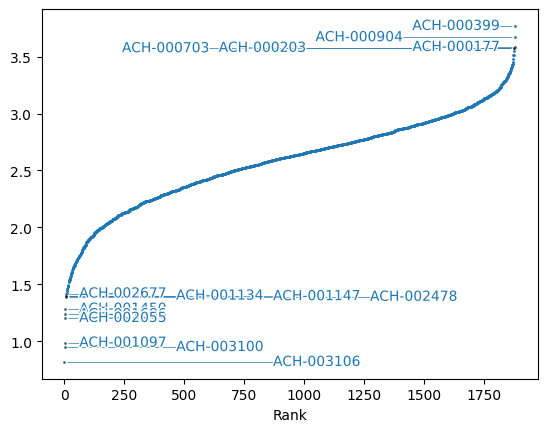

In [47]:
new_sample_median_expression = rnaseqc_count_mat_tpm.median(axis=1)
plotting.waterfall_plot(new_sample_median_expression, s=1)

Text(0.5, 0, 'All gene median expression')

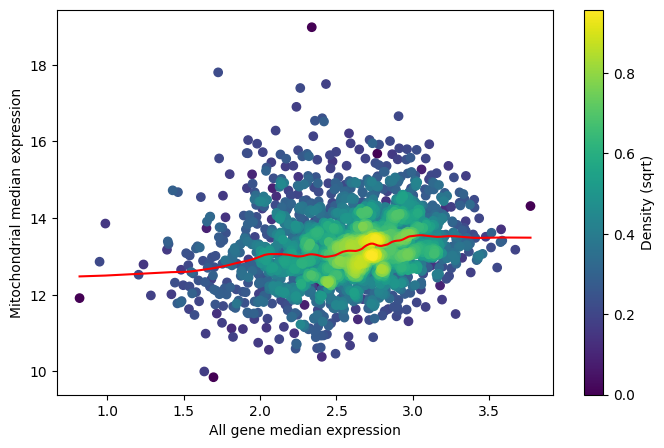

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
chrM_labels = rnaseqc_count_mat_tpm.columns[rnaseqc_count_mat_tpm.columns.str.contains("^MT-")]

plotting.density_scatter(rnaseqc_count_mat_tpm.loc[:, :].median(axis=1),
                         rnaseqc_count_mat_tpm.loc[:, chrM_labels].median(axis=1),
                         ax=ax)
ax.set_ylabel("Mitochondrial median expression")
ax.set_xlabel("All gene median expression")

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/cds/plotting/__init__.py:537: UserWarning: adjustText not found. Install to have labels moved off points.
  warn("adjustText not found. Install to have labels moved off points.")


(0.0, 18.0)

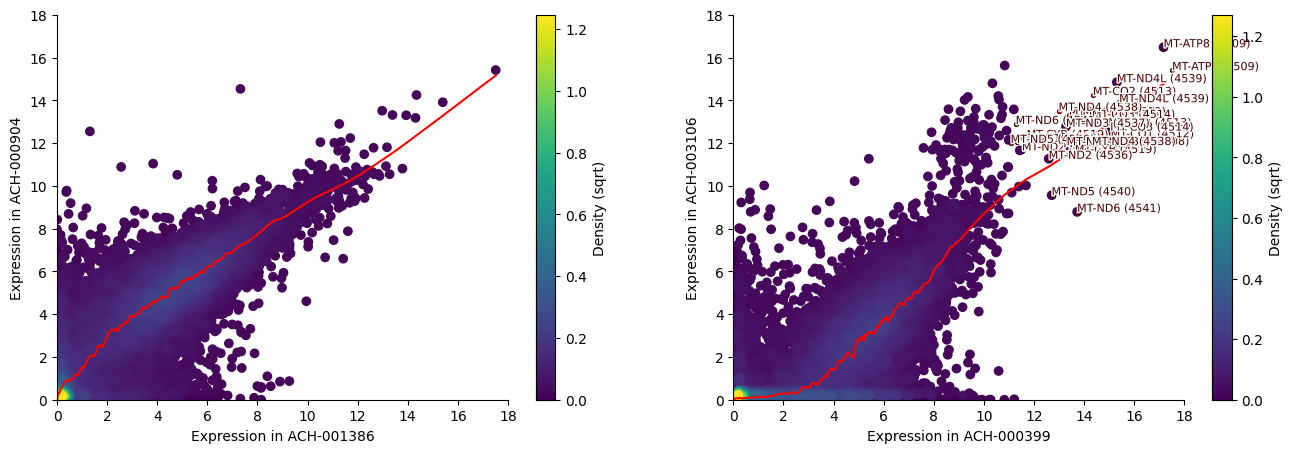

: 

In [49]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 5)
chrM_labels = rnaseqc_count_mat_tpm.columns[rnaseqc_count_mat_tpm.columns.str.contains("^MT-")]
highest_sample = rnaseqc_count_mat_tpm.loc['ACH-001386', :]
lowest_sample = rnaseqc_count_mat_tpm.loc['ACH-000904', :]
plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[0],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[0].set_xlabel("Expression in ACH-001386")
ax[0].set_ylabel("Expression in ACH-000904")
ax[0].set_xlim(0, 18)
ax[0].set_ylim(0, 18)


highest_sample = rnaseqc_count_mat_tpm.loc['ACH-000399', :]
lowest_sample = rnaseqc_count_mat_tpm.loc['ACH-003106', :]

plotting.density_scatter(highest_sample,
                         lowest_sample, ax=ax[1],
                         label_specific=chrM_labels)
sns.despine()
                         
ax[1].set_xlabel("Expression in ACH-000399")
ax[1].set_ylabel("Expression in ACH-003106")
ax[1].set_xlim(0, 18)
ax[1].set_ylim(0, 18)